# IS318 - Machine Learning

## TP3 - SVM and bag of features

In this TP, we will experiment with SVM classifiers. We will also work with K-Means clustering. We will apply these methods to a classical image classification approach called **bag of features**.

In [5]:
import sklearn
import sklearn.cluster
import sklearn.datasets
import sklearn.model_selection
import skimage.feature
import skimage.io
from sklearn.svm import SVC


from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, GroupKFold, cross_val_score

### 1. Introduction to SVM

In `scikit-learn` there exists several implementations of SVM. In this TP, we will use the `sklearn.svm.SVC` version, which allows to easily change the kernel used.

We will work a dataset of small images of faces called **Olivetti faces**. It is composed of 400 images of size 64x64, depicting 40 different persons.

In [6]:
olivetti_faces_dataset = sklearn.datasets.fetch_olivetti_faces()

**(Question)** Access the images and labels and set up an appropriate cross validation protocol.

(400, 4096)
(400, 64, 64)
(400,)
Train : (320, 4096) / (320,)
Test : (80, 4096) / (80,)


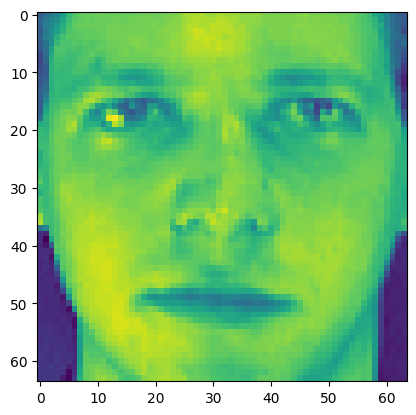

In [7]:
print(olivetti_faces_dataset["data"].shape)
print(olivetti_faces_dataset["images"].shape)
print(olivetti_faces_dataset["target"].shape)

n = len(olivetti_faces_dataset["target"])
train_threshold = int(n*0.8)

X_train = olivetti_faces_dataset["data"][:train_threshold]
y_train = olivetti_faces_dataset["target"][:train_threshold]

X_test = olivetti_faces_dataset["data"][train_threshold:]
y_test = olivetti_faces_dataset["target"][train_threshold:]

print(f"Train : {X_train.shape} / {y_train.shape}\nTest : {X_test.shape} / {y_test.shape}")

plt.imshow(olivetti_faces_dataset["images"][0], interpolation='nearest')
plt.show()



def get_cross_val_score(classifier_class, kwargs, X, y, kf):
    train_accuracies = []
    test_accuracies = []

    for train_index, test_index in kf.split(X, y):
        classifier = classifier_class(**kwargs)

        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

        classifier.fit(X_train, y_train)

        y_train_pred = classifier.predict(X_train)
        y_test_pred = classifier.predict(X_valid)

        train_accuracy = np.mean(y_train_pred == y_train)
        test_accuracy = np.mean(y_test_pred == y_valid)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies


**(Question)** Train a multi-class linear SVM classifier on this dataset with your cross-validation protocol. Report the classification accuracy on the validation/test set(s).

In [8]:
kf = KFold(n_splits=10, shuffle=False)
# kf = GroupKFold(n_splits=5)

# kwargs = {'C':1, 'kernel':'rbf'}
kwargs = {}
SVC_kf_train_accuracies, SVC_kf_test_accuracies = get_cross_val_score(SVC, kwargs, X_train, y_train, kf)

print(SVC_kf_train_accuracies, SVC_kf_test_accuracies)

[np.float64(0.9965277777777778), np.float64(0.9895833333333334), np.float64(0.9965277777777778), np.float64(0.9895833333333334), np.float64(0.9965277777777778), np.float64(0.9965277777777778), np.float64(1.0), np.float64(0.9826388888888888), np.float64(0.9930555555555556), np.float64(0.9965277777777778)] [np.float64(0.0625), np.float64(0.125), np.float64(0.15625), np.float64(0.0625), np.float64(0.0625), np.float64(0.0625), np.float64(0.09375), np.float64(0.0), np.float64(0.0625), np.float64(0.0625)]


**(Question)** Experiment with different hyperparameters (notably the soft margin parameter $C$) and different kernels. Compare the results.

In [9]:
kwargs = {'C':1, 'kernel':'rbf'}
SVC_kf_train_accuracies, SVC_kf_test_accuracies = get_cross_val_score(SVC, kwargs, X_train, y_train, kf)

print(SVC_kf_train_accuracies, SVC_kf_test_accuracies)

[np.float64(0.9965277777777778), np.float64(0.9895833333333334), np.float64(0.9965277777777778), np.float64(0.9895833333333334), np.float64(0.9965277777777778), np.float64(0.9965277777777778), np.float64(1.0), np.float64(0.9826388888888888), np.float64(0.9930555555555556), np.float64(0.9965277777777778)] [np.float64(0.0625), np.float64(0.125), np.float64(0.15625), np.float64(0.0625), np.float64(0.0625), np.float64(0.0625), np.float64(0.09375), np.float64(0.0), np.float64(0.0625), np.float64(0.0625)]


### 2. Scenes dataset

For the rest of the TP, to experiment with bag of features, we will work with the 8-scenes dataset originally from: https://people.csail.mit.edu/torralba/code/spatialenvelope/

It is provided as an archive file with this TP.

The function below can be used to load the dataset images and labels:

In [10]:
def load_scenes():
    '''Return images and labels of the scenes dataset.'''
    images = skimage.io.ImageCollection('scenes/*.jpg')
    labels_names = [f.split('/')[-1].split('_')[0] for f in images.files]
    unique_labels = sorted(list(set(labels_names)))
    labels_dict = {label: i + 1 for (i, label) in enumerate(unique_labels)}
    labels = np.array([labels_dict[label] for label in labels_names])
    return images, labels

**(Question)** Load the dataset and display some images of the different classes.

2686
(2686,)
(256, 256, 3) 1


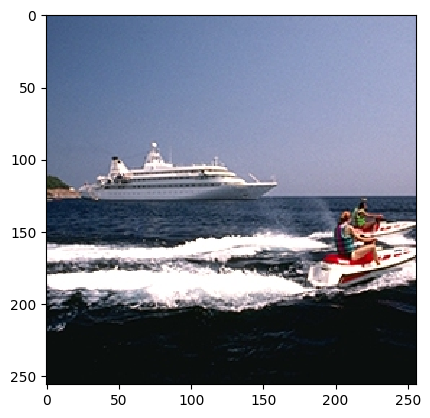

In [11]:
images, labels = load_scenes()

print(len(images))
print(labels.shape)

print(images[0].shape, labels[0])

plt.imshow(images[0], interpolation='nearest')
plt.show()

### 3. HOG features

Instead of working directly with image pixels (which would represent almost 200k dimensional features), we will be using an image feature descriptor called the Histogram of Oriented Gradients (HOG).

The principle of HOG is to compute a feature vector on several subregions of the image (called patches) for example of size 8x8. The image is then represented as a set of feature vectors corresponding to all patches.

The feature vectors computed are histograms of gradient orientations: the gradient of the image is computed (corresponding to its changes of intensity in each pixel), then the orientations of this gradient in each patch are accumulated into bins (here, we will be using 9 bins per patch).

In computer vision, HOG features are heavily related with the other well-known SIFT keypoints.

In [12]:
def hog_features(image):
    # Return a list of HOG features for a given image
    features = skimage.feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                   block_norm='L2-Hys', feature_vector=False, channel_axis=-1)
    features = features.reshape(-1, features.shape[-1])
    return features

**(Question)** Compute HOG features for some images. Take a look at the feature vectors obtained and try to understand what the dimensions correspond to.

In [13]:
hog_f = hog_features(images[0])
print((256*256)/(8*8))
print(hog_f.shape)

1024.0
(1024, 9)


**(Question)** Compute HOG features for the whole dataset. If it takes too long, you can directly load them from the provided `hog.tgz` file.

In [14]:
hog_file = 'hog.npy'
hog_features = np.load(hog_file)
print(hog_features.shape)
hog_features = np.reshape(hog_features, (-1, 9))

features_labels = np.repeat(labels, 1024).reshape((-1))

print(hog_features.shape)
print(features_labels.shape)

(2686, 1024, 9)
(2750464, 9)
(2750464,)


**(Question)** Split these features into train and test sets (for example 75% train, 25% test).

*Hint*: you can use the `train_test_split` method from `sklearn.model_selection`.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hog_features, features_labels, train_size=0.75, random_state=42)

print(X_train.shape)
print(X_test.shape)

(2062848, 9)
(687616, 9)


### 4. Bag of features

We will now implement the bag of features approach. It is composed on three main steps:
- Learn a vocabulary of visual words (also called codebook) using a clustering method (for example K-Means) applied on HOG features
- Project each feature of an image into the vocabulary, and build an histogram of these projections, giving a final single feature vector for the image
- Train an SVM classifier with these histograms of visual words as features for training images

**(Question)** Build the vocabulary of visual words with K-Means. The vocabulary size corresponds to the number of clusters.

In [16]:
from sklearn.cluster import MiniBatchKMeans

def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    kmeans = MiniBatchKMeans(n_clusters=voc_size, random_state=42, batch_size=1024)
    kmeans.fit(features)
    return kmeans

In [17]:
vocabulary = build_vocabulary(X_train, voc_size=100)

In [18]:
assert vocabulary.n_clusters == 100
assert vocabulary.n_features_in_ == 9

**(Question)** Try to understand the `build_codebook` function below. Then, compute the histograms of visual words for features of the train and test sets. Store the results into `X_train` and `X_test` variables.

In [19]:
def build_codebook(features, vocabulary):
    # Given a vocabulary of visual words (KMeans classifier object),
    # compute the codebook (histogram) of the set of features for an image
    voc_size = len(vocabulary.cluster_centers_)
    codebook = np.zeros((len(features), voc_size))
    for i, f in enumerate(features):
        assignemnts = vocabulary.predict(f.reshape((1, 9)))
        for k in range(voc_size):
            codebook[i][k] = len(np.where(assignemnts == k)[0])
    codebook = codebook / codebook.sum(axis=1)[:, np.newaxis] # normalization
    return codebook



import numpy as np  # noqa: E402
from joblib import Parallel, delayed  # noqa: E402

def build_codebook_distri(features, vocabulary, n_jobs=-1):
    voc_size = len(vocabulary.cluster_centers_)

    def compute_histogram(f):
        assignments = vocabulary.predict(f.reshape((1,9)))
        histogram, _ = np.histogram(assignments, bins=np.arange(voc_size+1))
        return histogram / histogram.sum()

    codebook = Parallel(n_jobs=n_jobs)(delayed(compute_histogram)(f) for f in features)
    return np.array(codebook)



In [20]:
# Build the codebooks for train and test features into X_train and X_test variables respectively
X_train = build_codebook_distri(X_train, vocabulary)
X_test = build_codebook_distri(X_test, vocabulary)



In [21]:
assert X_train.shape == (y_train.shape[0], 100)
assert X_test.shape == (y_test.shape[0], 100)

**(Question)** Explain what the `build_codebook` function does.

Answer : The function build_codebook generates a list of features containing integers which refer to the number of patches who are in that same cluster. This allows us to caracterize each image using the clusters of its patches. [TODO : improve this later]

**(Question)** Train an SVM classifier with the histograms of visual words and report the classification results. Analyze the results and try to improve the classification results by adjusting the hyperparameters.

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Train the SVM classifier with default parameters
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Report the classification results
print("Classification Results (Default SVM):")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


In [25]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Using LinearSVC for faster linear SVM training
svm = LinearSVC(random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# 
print("Classification Results (LinearSVC):")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Classification Results (LinearSVC):
              precision    recall  f1-score   support

           1       0.25      0.49      0.33     91886
           2       0.23      0.60      0.33     84128
           3       0.30      0.03      0.06     66340
           4       0.28      0.06      0.10     78530
           5       0.21      0.17      0.19     95613
           6       0.20      0.17      0.19    105323
           7       0.42      0.03      0.06     74915
           8       0.28      0.30      0.29     90881

    accuracy                           0.24    687616
   macro avg       0.27      0.23      0.19    687616
weighted avg       0.27      0.24      0.20    687616

Accuracy: 0.2416


**(Question)** Propose a visualization of some of the visual words learned by your bag of features model.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()